In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from sklearn.model_selection import KFold

In [2]:
#Get Data from:
# https://drive.google.com/uc?export=download&id=1Dh4YNn9Al_DQ_8nLQ_A7Za2Xw_SqmYB8
#Read Data
standardized_df=pd.read_excel('Standardized_df.xlsx')
fhr=pd.read_excel('FHR.xlsx')

In [3]:
from sklearn import preprocessing
label = preprocessing.LabelEncoder()
y1=label.fit(np.ravel(fhr)).transform(np.ravel(fhr))
y1

array([8, 5, 5, ..., 4, 4, 0], dtype=int64)

In [4]:
#Transform Data
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y1)
y = lb.transform(y1)
x=standardized_df.to_numpy()

In [20]:
def kf(neurons,batch):
  global accuracy, loss,data_yhat
  kfold = KFold(n_splits=5, shuffle=False)
  fold_no = 1
  accuracy=[]
  loss=[]
  predicted_classes=[]
  data_y=[]
  data_yhat =[]

  for train, test in kfold.split(x,y):
    
    model = Sequential()
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons-10, activation='relu'))
    #model.add(Dense(neurons-10, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #Get Data
    train_x, test_x = x[train], x[test]
    train_y, test_y = y[train], y[test]


    save_model_name = os.path.join('./models/model_classifier.h5')
    saveBest = ModelCheckpoint(save_model_name, monitor='val_loss', save_best_only=True)
    earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=0, mode='auto')

    # Fit data to model and predict
    model.fit(train_x, train_y, batch_size=batch,epochs=25, verbose=0, validation_split=0.10, callbacks=[saveBest,earlyStopping])
    predicted_classes=model.predict(test_x, batch_size=batch)

    # Generate generalization metrics
    scores = model.evaluate(test_x, test_y, verbose=0)
    # store
    data_y.extend(test_y.tolist())
    data_yhat.extend(predicted_classes)
    
    accuracy.append(round(scores[1]*100,2))
    loss.append(round(scores[0]*100,2))

    # Increase fold number
    fold_no += 1

In [101]:
#Find best number of neurons
all_acc=[]
all_loss=[]
neurons=[20,30,40,50,60,70,80,90,100,110,120]
for n in range(len(neurons)):
    kf(neurons[n],1)
    all_acc.append(round(mean(accuracy),2))
    all_loss.append(round(mean(loss),2))
all_stats=pd.DataFrame()
all_stats['Accuracy']=all_acc
all_stats['Loss']=all_loss
all_stats['Neurons']=neurons
all_stats.set_index('Neurons', inplace=True)
all_stats.to_excel('All_stats.xlsx', index=True, header=True)
all_stats

,Accuracy,Loss
Neurons,,
20,70.79,84.50
30,70.37,82.09
40,72.34,77.33
50,67.97,95.25
60,71.40,93.88
70,72.86,88.02
80,72.06,95.05
90,71.36,88.17
100,72.11,81.69


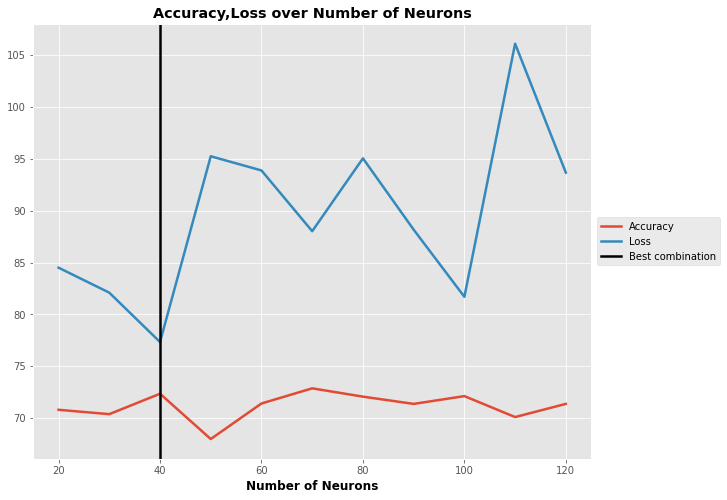

In [156]:
plt.figure(figsize=(10,8))
plt.plot(all_stats['Accuracy'],linewidth=2.5, label='Accuracy')
plt.plot(all_stats['Loss'],linewidth=2.5,label='Loss')
plt.axvline(x = 40, linewidth=2.5, color = 'k', label = 'Best combination')

plt.xlabel('Number of Neurons', fontweight='bold',c='black')

plt.style.use('ggplot')
plt.legend(loc='center right')
plt.legend(bbox_to_anchor=(1, 0.5), loc=6, borderaxespad=0.6)

plt.title("Accuracy,Loss over Number of Neurons",fontweight='bold',c='black')

plt.savefig("Neurons", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#Kfold for picked number of neurons
kf(40,1)
from numpy import mean
acc=list(map("{}%".format, accuracy))
l=list(map("{}%".format, loss))

In [18]:
from prettytable import PrettyTable
from prettytable import PLAIN_COLUMNS 
t1=PrettyTable()
t1.set_style(PLAIN_COLUMNS)

t1.add_column("Fold_id", list(range(1,6)))
t1.add_column("Accuracy per fold", acc)
t1.add_column("Loss per fold", l)
print(t1)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

t2=PrettyTable()
t2.set_style(PLAIN_COLUMNS)
t2.field_names=["Accuracy","Loss"]
t2.add_row((str(round(mean(accuracy),2))+"%", str(round(mean(loss),2))+"%"))
print(t2)

Fold_id        Accuracy per fold        Loss per fold        
   1                 66.67%                 80.83%           
   2                 68.0%                  83.0%            
   3                 79.06%                 55.57%           
   4                 72.94%                 78.26%           
   5                 62.59%                 149.1%           
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy         Loss         
 69.85%         89.35%        


In [8]:
pred_class=np.argmax(data_yhat, axis=1)

In [12]:
from sklearn.metrics import classification_report
dict_report=classification_report(y1,pred_class, output_dict=True)
report=pd.DataFrame(dict_report).transpose()
report.to_excel("Classification_Report.xlsx")
report

,precision,recall,f1-score,support
0,0.671429,0.611979,0.640327,384.000000
1,0.855903,0.851468,0.853680,579.000000
2,0.600000,0.396226,0.477273,53.000000
3,0.643836,0.580247,0.610390,81.000000
4,0.472727,0.361111,0.409449,72.000000
5,0.875433,0.762048,0.814815,332.000000
6,0.712025,0.892857,0.792254,252.000000
7,0.864198,0.654206,0.744681,107.000000
8,0.546667,0.594203,0.569444,69.000000
9,0.561594,0.786802,0.655391,197.000000


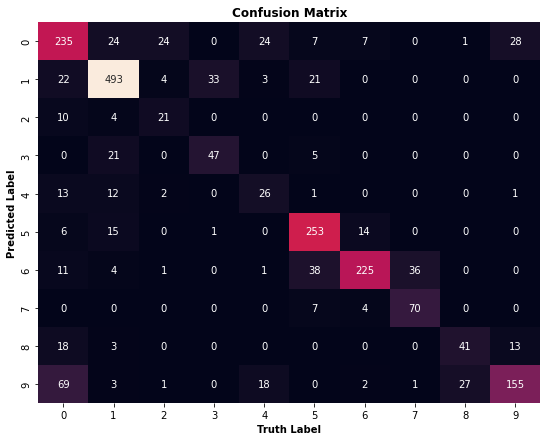

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y1, pred_class)


plt.figure(figsize=(9,7))
sns.heatmap(cm.T, annot=True, square=False , cbar=False, fmt='d', 
            yticklabels=np.unique(pred_class),
            xticklabels=np.unique(y1))

plt.ylabel("Predicted Label", fontweight='bold',c='black')
plt.xlabel("Truth Label", fontweight='bold',c='black')
plt.title("Confusion Matrix", fontweight='bold',c='black')
plt.savefig("CM_model", dpi=300, bbox_inches='tight')
plt.show()